In [407]:
import gym_duckietown
import matplotlib.pyplot as plt
import numpy as np

from gym_duckietown.simulator import Simulator
from IPython import display as ipythondisplay
from casadi import *

from utils import get_trajectory, get_position

In [408]:
# Hyperparameters
test_results = True
T = 15 # Time horizon
N = 3 # Number of control intervals BEST UNTIL NOW: 25

In [409]:
plt.rcParams['figure.figsize'] = [7, 7]

In [410]:
#gym_duckietown is very chatty
import logging
gym_duckietown.logger.setLevel(logging.WARNING)

In [411]:
env = Simulator("small_loop",
    full_transparency=True,
    domain_rand=False,
    user_tile_start=[1,0],
    seed=42,
    max_steps=float("inf"),
)

In [412]:
env.unwrapped.start_pose = [[0.11699990272521976, 0, 0.41029359288296474], 0]

In [413]:
env.reset()
traj = get_trajectory(env, samples=200)

/home/giulio/prog/duckrace_simulator/utils.py:235: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  points_fitted = np.vstack( spl(alpha) for spl in splines ).T


In [414]:
pose = get_position(env)
pose

Position(x=0.7019999027252197, y=1.3447064071170352, theta=0)

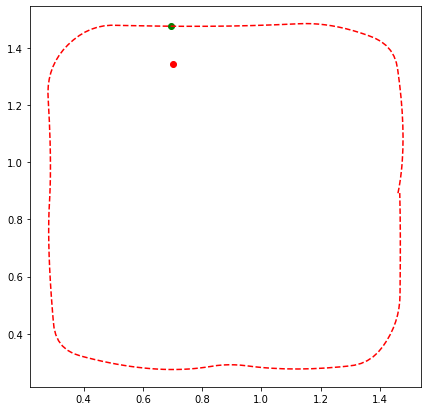

In [415]:
from scipy import spatial
distance,index = spatial.KDTree(traj).query([pose.x, pose.y])
plt.plot(*traj.T, "r--")
plt.scatter(pose.x, pose.y, c="r")
plt.scatter(traj[index,0], traj[index,1], c="g")

In [416]:
index = DM(index)
traj = DM(traj)

Initialize states, inputs, and system dynamic equation

In [417]:
dt = 1.0 / env.frame_rate

In [418]:
up = 5
wp = 4
# parameters for forced dynamics
u_alpha_r = 1.5
u_alpha_l = 1.5
w_alpha_r = 15  # modify this for trim
w_alpha_l = 15

In [419]:
pose = get_position(env)

DAE

In [420]:
# States
x0 = MX.sym('x')
y0 = MX.sym('y')
th0 = MX.sym('th')
v0 = MX.sym('v')
w0 = MX.sym('w')
x = vertcat(x0, y0, th0, v0, w0) # Always vertically concatenate the states --> [n_x,1]
# Inputs
wl = MX.sym('wl')
wr = MX.sym('wr')
u = vertcat(wl, wr) # Always vertically concatenate the inputs --> [n_u,1]
# System dynamics (CAN BE NONLINEAR! ;))
# x_long_dot_dot = -u1*v0 + u_alpha_r*wr + u_alpha_l*wl
# w_dot_dot = -w1*w0 + w_alpha_r*wr - w_alpha_l*wl
v1 = (1-up*dt)*v0 + u_alpha_r*dt*wr + u_alpha_l*dt*wl
w1 = (1-wp*dt)*w0 + w_alpha_r*dt*wr - w_alpha_l*dt*wl
x1 = x0 + v0*dt*np.cos(th0 + w0*dt/2)
y1 = y0 + v0*dt*np.sin(th0 + w0*dt/2)
theta1 = th0 + w0*dt
dae = vertcat(x1, y1, theta1, v1, w1)
F = Function('F',[x,u],[dae],['x','u'],['dae'])
if test_results:
    print(F([pose.x, pose.y, pose.theta, 0, 0], [1, 1]))

[0.70199990272522, 1.34470640711704, 0, 0.1, 0]


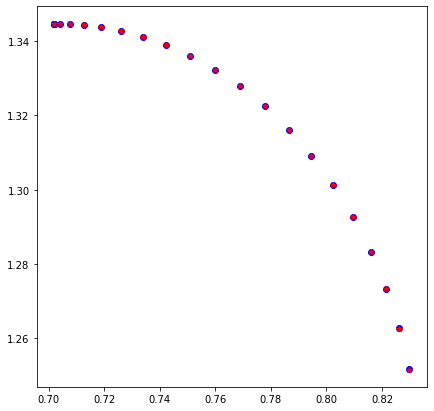

In [421]:
N_test=20
# Test the problem definition
sim = F.mapaccum(N_test) # To call the F function N times
x0 = [pose.x, pose.y, pose.theta, 0, 0]
res = sim(x0, [1, 0.2])
fig = plt.figure()
tgrid = np.linspace(0,T,N)
# plt.plot(tgrid, np.column_stack((x0, res)).T)
plt.plot(res[0, :], res[1, :], 'r*')
env.reset()
for action in [[1, 0.2]]*(N_test+3):
    obs, reward, done, info = env.step(action)
    p = get_position(env)
    plt.scatter(p.x, p.y, c='b')
_ = env.reset()

In [422]:
opti = Opti() # Special CasADi stack for optimization

x = opti.variable(5,N+1)    # States with dimension (n_x, prediction_horizon+1) (x(0),...,x(N+1))
u = opti.variable(2,N)      # Inputs with dimension (n_u, prediction_horizon) (u(0),...,u(N))
p = opti.parameter(5,1)     # Parameter to set the initial state conditions (x(0))
# idx = opti.parameter(1,1)   # Parameter to set the initial index

Q, R = 1, 0
r = repmat(traj[index, :].T, 1, N+1)
obj = Q*sumsqr(x[:2, :]-r) + R*sumsqr(u)   # Objective function: (NOT NECESSARILY quadratic!)

opti.minimize(obj)          # Setup the problem 

# Constraints Definition

# 1) System dynamics constraint over the prediction horizon
for k in range(0,N):
   opti.subject_to(x[:,k+1]==F(x[:,k],u[:,k])) # System dynamics is called through F, that we defined above as the DAE that maps (x,u) --> (x,next)
    
# 2) Additional states/inputs constraints 
opti.subject_to(vec(u) <= 1)
opti.subject_to(vec(u) >= -1)
# 3) Force the state variable at instant 0 to be equal to the parameter value containing x0 value
opti.subject_to(x[:,0]==p)

opti.set_value(p,[pose.x, pose.y, pose.theta, 0, 0]) # Set the initial x0 value
# opti.set_value(idx,index) # Set the initial index

# Set additional options
# opts = dict()
# opts["qpsol"] = "qrqp" # Solver! See the docs for information
# opts["print_header"] = False
# opts["print_iteration"] = True
# opts["print_time"] = False
# opts["qpsol_options"] = dict({"print_iter":False,"print_header":False,"print_info":False,"error_on_fail":False})
# opti.solver("sqpmethod", opts)

# Ipopt ?
opts = dict()
opts["ipopt.print_level"] = 0
opts["print_time"] = False
opti.solver('ipopt',opts)

# If you want to test over 1 time horizon
if test_results:
    sol = opti.solve()

Final Step: run the MPC control loop!
N.B. Given that we want to simulate the system, e.g., 50 timesteps,
1. at each time step the previosly defined optimization problem computes inputs u and predicted states x in the prediction horizon N.
2. from computed sequence of inputs (u(0), ..., u(T)), ONLY u(0) value is selected to simulate the system
3. (x0, u(0)) --> x_next == x(1)
4. the loop restart

In [423]:
# This instruction transfom all the Opti problem defined above into a callable function
M = opti.to_function('M',[p],[u[:,0]],['p'],['u_opt'])

In [424]:
# MPC loop
X_log = np.empty((5,0))
U_log = np.array([])

x = [pose.x, pose.y, pose.theta, 0, 0]
for i in range(80):
    u = M(x)

    U_log = np.append(U_log, u)
    X_log = np.column_stack((X_log, x))

    # simulate
    x = F(x,u)

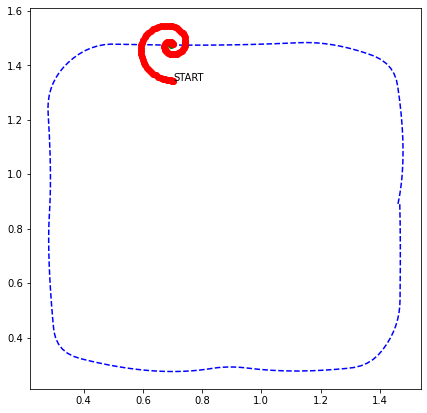

In [425]:
plt.text(X_log[0,0], X_log[1,0], 'START')
plt.plot(traj[:,0], traj[:,1], "b--")
plt.plot(traj[index,0], traj[index,1], 'go')
plt.plot(X_log[0,:], X_log[1,:], 'ro')

If you want to save the MPC controller, i.e. the M function for later use, you can do it!

In [426]:
M.save('M.casadi')
M2 = Function.load('M.casadi')
DM.set_precision(15)
print(M(x0))
print(M2(x0))

[-0.214223794243045, -0.999968672105714]
[-0.214223794243045, -0.999968672105714]
